# <center>Overview
This project analyzes the Ramen Ratings dataset from Kaggle. This dataset has a few thousand ramen products and their ratings, from 0 to 5 stars. The data includes the review number, the ramen's brand, product name, packaging style, country of origin, rating, and whether or not the ramen is in the top 10. I chose to make this a one-vs-rest classification problem on whether a ramen is rated five stars or not. The analysis uses independence tests and feature engineering to arrive at key drivers of five-star ratings, then uses these features to build a predictive model. The project successfully identified key drivers using these methods and build a predictive model that performs better than a standard baseline for the work.

## The cool new stuff I accomplished for this project
- **Heavy keyword engineering**
    * Domain research to understand ramen products based on keyword
    * Translation to group all keywords into consistent categories
    * Categorization on common factors based on domain research and translation
- **Multi-layered statistical testing to eliminate features**
    * Chi-Square tests to eliminate initial features that are not related to target
    * One-hot encoding of remaining features' categories
    * Chi-Square tests to eliminate one-hot-encoded categories that are not related to target
- **Clustering country and keyword features into low-, medium-, and high-rate five-star ratings groups**
    * Checked proportions of five-star rating counts against not-five-star rating counts for True in encoded feature
    * Checked proportions of five-star rating counts against not-five-star rating counts for False in encoded feature
    * Compared five-star proportions to check increase/decrease in proportion from False to True
    * Bracketed increasing, middle, and decreasing proportions from False to True
    
## Other stuff that I've done before
- Wrangle
    * Categorize and encode target into five_stars column (classes: is five-stars, isn't five stars)
    * Fix some values, drop some nulls, outliers, and duplicate rows, get rid of unnecessary columns
    * Create univariate visualizations
- Explore
    * Run Chi-Square testing to determine if feature is related to target
    * Feature engineering (overall)
    * Create bivariate visualizations
    * Choose features for model
- Model
    * Choose optimization priorities for the model (F1 Score)
    * Resample the target to address class imbalance
    * Create baseline model and multiple algorithmic models with varying hyperparameter combinations
    * Evaluate models on Validate (first out-of-sample split)
    * Choose best three models in terms of our optimization priority
    * Use GridSearchCV to choose best hyperparameters for top models
    * Calculate ROC AUC of baseline and models
    * Choose best model across all metrics
    * Evaluate baseline and best model on Test split
    
## Findings
1. The brand of ramen does not influence whether or not the ramen product has a five-star rating.
1. The packaging of ramen does not influence whether or not the ramen product has a five-star rating.
1. A ramen's country of origin has an influence on whether or not the ramen product has a five-star rating.
    - Malaysia has the highest five-star rating proportion of all origin countries.
    - Ramen originating from Malaysia, Singapore, or Taiwan have the highest proportion of five-star ratings.
    - Ramen from Hong Kong, Japan, South Korea, or Indonesia have the next-highest proportions of five-star ratings.
    - Ramen from China, Thailand, or USA have the lowest proportions of five-star ratings.
    - China has the lowest five-star rating proportion of all origin countries.
1. A ramen's noodle type does not influence whether or not the ramen product has a five-star rating.
1. A ramen's flavor influences whether or not the ramen product has a five-star rating.
    - Curry flavor has the highest proportion of five-star ratings for all flavor categories.
    - Ramen with curry or sesame flavor have the highest proportions of five-star ratings.
    - Ramen with pork flavor or the common crustaceans have the next-highest proportions of five-star ratings.
    - Chicken- and beef- flavored ramen products have the lowest five-star rating proportions of all flavors.
    - Chicken flavor has the lowest five-star rating proportions of all flavors.
1. A ramen's spicy status influences whether or not the ramen product has a five-star rating.
1. A ramen's fried status does not have an effect on whether or not the ramen product has a five-star rating.

## Model Results
- Features used: country and flavor brackets (as described above) and spicy status
- Evaluation Metric: F1 Score
- Best model: Logistic Regression
- Model performance: outperforms the baseline on F1 Score and ROC AUC for unseen data

# <center>Imports

In [1]:
# cull warnings
import warnings
warnings.filterwarnings('ignore')

# standard imports
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# top three modeling algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# evaluation functions
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score

# scripts
import wrangle
import explore
import model

# <center>Wrangle
## Bottom Line Up Front: What I Did for Wrangle
1. Acquire ramen-ratings.csv from Kaggle
1. Rename a United States value to USA
1. Drop low-count ramen styles Box, Can, and Bar (8 rows)
1. Drop countries with less than 5 cumulative observations (29 rows)
1. Drop Unrated, nulls and duplicates (16 rows)
1. Replace Stars column with five_stars column
1. Drop 'Review #' and 'Top Ten' columns
1. Rename columns for easier exploration
1. Split cleaned data into Train, Validate, and Test splits for exploration and modeling

In [2]:
# wrangle.py script to wrangle the data as described above
train, _, _ = wrangle.prep_explore()

train.head(3)

Train size: (1515, 5) Validate size: (506, 5) Test size: (506, 5)


,brand,name,package,country,five_stars
2566,Samyang,Hot,Pack,South Korea,False
332,Nongshim,Shin Noodle Soup,Cup,USA,True
1363,Doll,Hello Kitty Dim Sum Noodle Japanese Curry Flavour,Cup,Hong Kong,False


# <center>Explore
## Bottom Line Up Front: What I Did for Explore
- Statistical testing on Ramen Brands that found brand is independent of five-star outcomes
- Statistical testing on Ramen Packaging that found packaging is independent of five-star outcomes
- Statistical testing on Country of Origin that found country is related to five-star outcomes
- Keyword engineering to categorize ramen products into noodle type, flavor, spicy status, and fried status categories
- Statistical testing on new features that found noodle type and fried status have no impact on five-star outcomes
- Statistical testing on new features that found ramen flavor and spicy status have an impact on five-star outcomes
- Dropped specific countries and flavors that did not have at least 5 reviews with five-star rating
- Analyzed proportions of five-star reviews to all reviews for each country and flavor category
- Grouped into high-, medium-, and low-proportion brackets for country and for flavor category
- Checked country and flavor category brackets along with spicy status in terms of five-star and non-five-star reviews
- Chose these features for modeling

## Ramen Brand is Independent
- $H_0$: Ramen brand and five-star ratings are independent.
- $H_a$: Ramen brand and five-star ratings have a dependent relationship.

Confidence interval: 95%

In [3]:
# run chi-square test on ramen brand
explore.chi2_ramen_brand(train)

Ramen brand and five-star ratings are independent, did not pass 95% confidence interval.
p-value: 0.223


## Ramen Packaging is Independent

- $H_0$: Packaging and five-star ratings are independent.
- $H_a$: Packaging and five-star ratings have a dependent relationship.

Confidence interval: 95%

In [4]:
# run chi-square test on ramen packaging
explore.chi2_ramen_packaging(train)

Packaging and five-star ratings are independent, did not pass 95% confidence interval.
p-value: 0.439


## Ramen Country of Origin is Related

- $H_0$: Country of origin and five-star ratings are independent.
- $H_a$: Country of origin and five-star ratings have a dependent relationship.

Confidence interval: 95%

In [5]:
# run chi-square test on ramen country of origin
explore.chi2_ramen_origin_country(train)

Country of origin and five-star ratings have a dependent relationship with 95% confidence.
p-value: 0.0


## Breaking Down the Ramen Product Name
### Why We Needed to Engineer Features for Product Name
Nearly all ramen reviews in our dataset have a unique combination of brand and product name. Only 21 combinations of brand and product out of the nearly 1500 in our exploration split have two reviews, and there are no combinations with more than two reviews. Because of this low commonality, we couldn't run initial chi-square tests to see if product names have a dependent relationship with five star reviews.

In [6]:
# show the review repeats and non-repeats
print("Brand+name with only one review:", (train[['brand','name']].value_counts() == 1).sum())
print("Brand+name with two reviews:", (train[['brand','name']].value_counts() == 2).sum())
print("Brand+name with more than two reviews:", (train[['brand','name']].value_counts() > 2).sum())

Brand+name with only one review: 1473
Brand+name with two reviews: 21
Brand+name with more than two reviews: 0


### Identifying Keywords
I've designated certain keywords that I will use to categorize product names. Although that raw list is contained in the explore.py script, the analysis in this notebook will break it down into an organized format.

Based on the designated keywords, I ran the following two cells to check remaining values that I missed earlier. If I found a notable word, I added it to the above keyword list and re-ran the cells. I repeated this process until I was satisfied with the words I had designated as keywords.

In [7]:
# create has_keyword column, check value counts
explore.create_has_keyword(train).has_keyword.value_counts()

True     1377
False     138
Name: has_keyword, dtype: int64

In [8]:
# check top-10 words
explore.check_non_keywords(train)

Noodles    34
Noodle     30
Ramen      19
Instant    16
Cup        14
Flavour    11
Sauce      11
Flavor     10
Rasa        9
Mi          8
dtype: int64


### Categorization Using Domain Research and Translation
During and after creating this keyword list, I conducted background research and translation on keywords for the purposes of categorization. **This process took the most time of any step in this project.** 

I built the categories from scratch and researched whether a word indicated the product belonged to the category or not. After many iterations of this category creation and attribution, I came up with four features, which will be shown later. An early result of this process is contained here as an example.

**Taste**
* 'Spicy', 'Spice', 'Shin', 'Jjamppong'/'Jjambbong'(seafood), 'Buldalk'(chicken), 'Sutah'(beef), 'Budae'(sausage), 'Habanero', 'Jinjja', 'Jin', 'Yeul', 'Mala', 'Teumsae', 'Bibim', 'Picante', 'Bulnak', 'Volcano', 'Odongtong', 'Sriracha', 'Arrabiata', 'Tom Yum', 'Tom Yam', 'Tom Saab', 'Tom Klong', 'Suki', 'Laksa' (304)
* 'Ramyonsari', 'Keopnurungji' (2)
* 'Salt', 'Shio', 'Sio' (17)
* 'Soy', 'Shoyu', 'Shouyu', 'Teriyaki' (70)
* 'Mayo' (6)
* 'Cheese' (11)
* 'Sweet' (18)
* 'Sour', 'sour' (19)
* 'Curry' (68)
* 'Sesame' (32)
* 'Pickle' (11)
* 'Masala' (9)

As you can see, I grouped keywords loosely here and checked how many products contained at least one of the keywords in each bulletpoint. The code to check that number is shown below as an example.

In [9]:
# checking row count having the above noodle types (ran this cell multiple times with different inputs)
train.name.str.contains("|".join(['Soy', 'Shoyu', 'Shouyu', 'Teriyaki'])).sum()

70

### Choosing Candidate Features
After creating these rough categories and checking row counts, we were able to begin considering what features we should use in our analysis. 
#### Requirements
1. A feature must have at least two unique values 
    * EX: A 'meat_type' feature must have at least two categories, like 'chicken', 'beef', 'pork', etc
1. Each unique value in the feature must have a count of at least 10
    * Assumption of chi-square test: each crosstab cell must have at least a value of 5
    * Anything less than 10, when split for the crosstab, will not meet this chi-square assumption
    * EX: 'chicken' should have at least a count of 10
1. The feature's values should be independent from one another 
    * EX: 'taste_type' should not have individual 'sweet' and 'sour' values because some ramen have 'sweet & sour' in the product name
    
#### Features that Pass the Above Requirements
- noodle_type: 
    * **wheat** ('Udon', 'Udoin', 'U-Dong', 'U-dong', 'Sano', 'Spaghetti', 'Carbonara', 'Neapolitan', 'Napolitan', 'Kalguksoo') (63)
    * **buckwheat** ('Buckwheat', 'Soba') (18)
    * **rice** ('Rice', 'Vermicelli', 'Vernicalli', 'Bihun', 'Biryani', 'Tteokbokki', 'Tteobokki', 'Topokki', 'Rabokki') (109)
- flavor: 
    * **miso** ('Miso') (23)
    * **chicken** ('Chicken', 'Chikin', 'Duck', 'Pollo', 'Buldalk', 'Buldak', 'Requeijao', 'Gallina') (215)
    * **beef** ('Beef', 'Gomtang', 'Seolleongtang', 'Sukiyaki', 'Nam Tok', 'Sutah', 'Sogokimyun', 'Cuchareable', 'Carne', 'Kebab', 'Gentong', 'Bulalo', 'Yukgaejang') (163)
    * **pork** ('Pork', 'Prok', 'Jjajangmyeon', 'Jjajangmen', 'Jiajang', 'Jjajang', 'Chacharoni', 'Jjawang', 'Tonkotsu', 'Tomkotsu', 'Bacon', 'Ossyoi', 'Yakibuta', 'Batchoy') (115)
    * **crustacean** ('Crab', 'Lobster', 'Shrimp', 'Prawn') (108)
    * **mollusk** ('Bajirak', 'Clam', 'Abalone', 'Scallop', 'Vongole') (15)
    * **chili** ('Chili', 'Chilli', 'chili', 'Cabe') (37)
    * **curry** ('Curry', 'curry', 'Betawi', 'Perisa', 'Kari') (93)
    * **chow_mein** ('Chow Mein') (25)
    * **kimchi** ('Kimchi', 'Kimchee', 'Sabalmyeon', 'Kim Chee') (24)
    * **mushroom** ('Mushroom', 'Shiitake', 'Shitake') (35)
    * **tomato** ('Tomato') (21)
    * **veggie** ('Clear', 'Veg', 'Oosterse') (86)
    * **sesame** ('Sesame', 'Sesami') (33)
    * **lime** ('Lime', 'Jeruk Nipis', 'Kalamansi') (11)
- spicy:
    * **True** ('Spicy', 'Spice', 'Shin', 'Jjamppong'/'Jjambbong'/'Jjampong'/'Champong'(seafood), 'Buldalk'/'Buldak'(chicken), 'Sutah'(beef), 'Budae'(sausage), 'RMy', 'Habanero', 'Jinjja', 'Jin', 'Yeul', 'Mala', 'Teumsae', 'Bibim', 'Picante', 'Bulnak', 'Volcano', 'Odongtong', 'Sriracha', 'Arrabiata', 'Tom Yum', 'Tom Yam', 'tom Yum', 'Tom Saab', 'Tom Klong', 'Suki', 'Laksa', 'Chah Chiang', 'Namja', 'Befikr', 'Mi Goreng', 'Kocek', 'Jalapeno', 'Pad Kee Mao', 'Kokomen', 'Wasabi', 'Kung Pao', 'Kimchi', 'Kimchee', 'Sabalmyeon', 'Kim Chee', 'Nam Tok', 'Sogokimyun', 'Gentong', 'Chili', 'Chilli', 'chili', 'Cabe', 'Yukgaejang', 'Yakisoba', 'Yaki-Soba', 'Yakiosoba') (446)
    * **False** ('Miso', 'Requeijao', 'Seolleongtang', 'Sukiyaki', 'Jjajangmyeon', 'Jjajangmen', 'Jiajang', 'Jjajang', 'Chacharoni', 'Jjawang', 'Ossyoi', 'Batchoy', 'Bajirak', 'Mushroom', 'Shiitake', 'Shitake', 'Tomato', 'Clear') (99)
- fried:
    * **True** ('Stir Fry', 'Stir-Fried', ' Fried', 'Bokkeum', 'Tteokbokki', 'Tteobokki', 'Topokki', 'Yukgaejang', 'Rabokki', 'Yakisoba', 'Yaki-Soba', 'Yakiosoba', 'Goreng', 'Tempura', 'Kung Pao', 'Sukiyaki', 'Kebab', 'Gentong', 'Bulalo', 'Jjajangmyeon', 'Jjajangmen', 'Jiajang', 'Jjajang', 'Chacharoni', 'Jjawang', 'Tonkotsu', 'Tomkotsu', 'Bacon', 'Yakibuta', 'Batchoy', 'Chow Mein') (198)
    * **False** ('Non-Fried', 'Requeijao', 'Yakisoba', 'Yaki-Soba', 'Yakiosoba', 'Gomtang', 'Seolleongtang', 'Nam Tok', 'Sutah', 'Sogokimyun', 'Cuchareable', 'Gomtang', 'Yukgaejang', 'Ossyoi', 'Clear') (52)
    
### Creating the Features, Testing for Relationship to Target
After background research and translation, after several rounds of categorization, after restricting categories for testing, and after choosing features that will maintain independence between categories, we finally have something to work with. 

Now, we will create each feature as described above, then test each feature to see if they have a relationship with our target, five_stars.

#### noodle_type

In [10]:
# create noodle_type feature
train = explore.create_noodle_type(train)
# test noodle_type for independence
explore.chi2_ramen_noodle_type(train)

Noodle type and five-star ratings are independent, did not pass 95% confidence interval.
p-value: 0.725


#### flavor

In [11]:
# create flavor feature
train = explore.create_flavor(train)
# test flavor for independence
explore.chi2_ramen_flavor(train)

Flavor and five-star ratings have a dependent relationship with 95% confidence.
p-value: 0.0


#### spicy

In [12]:
# create spicy feature
train = explore.create_spicy(train)
# test spicy for independence
explore.chi2_ramen_spicy_status(train)

Spicy status and five-star ratings have a dependent relationship with 95% confidence.
p-value: 0.014


#### fried

In [13]:
# create fried feature
train = explore.create_fried(train)
# test fried for independence
explore.chi2_ramen_fried_status(train)

Fried status and five-star ratings are independent, did not pass 95% confidence interval.
p-value: 0.282


### Results of Breaking Down Product Name
**Through feature engineering and statistical testing, the features 'flavor' and 'spicy' will join 'country' in our univariate and bivariate analysis.**

In [14]:
# limit dataframe to the candidate features
train = train[['five_stars','country','flavor','spicy']]
train['five_stars'] = train['five_stars'].astype('str')

# Univatiate Look at Our Candidate Features
Let's look at histograms for each feature and the target.

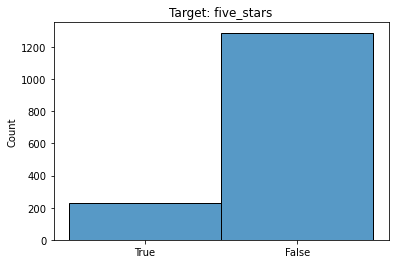

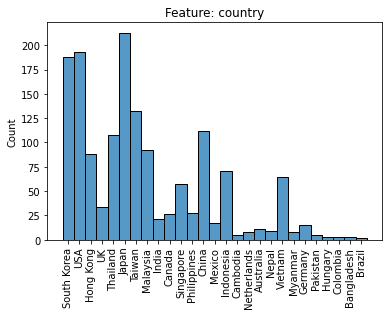

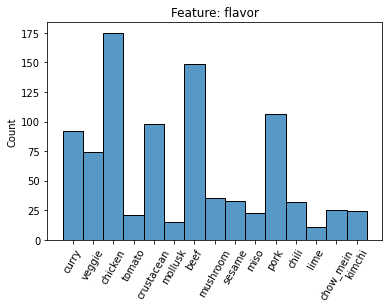

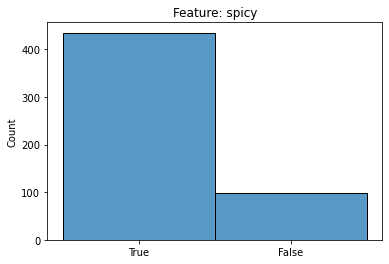

In [15]:
# initial univariate histograms
sns.histplot(train.five_stars.sort_values(ascending=False)) # five_stars
plt.title('Target: five_stars')
plt.xlabel('')
plt.show()

sns.histplot(train.country) # country
plt.title('Feature: country')
plt.xticks(rotation=90)
plt.xlabel('')
plt.show()

sns.histplot(train.flavor.dropna()) # flavor
plt.title('Feature: flavor')
plt.xticks(rotation=60)
plt.xlabel('')
plt.show()

sns.histplot(train.spicy.dropna().sort_values(ascending=False)) # spicy
plt.title('Feature: spicy')
plt.xlabel('')
plt.show()

The features 'country' and 'flavor' have multiple categories. We will need to split these categories out for modeling.

# Each Country and Flavor Into Brackets
We need to split out the country and flavor columns to make visual comparison easier. To do this, we will eliminate values that do not meet statistical minimums and create features for the values that meet requirements.

## Country
### Check Total Reviews and Number of Five-Star Reviews
We will look at three metrics for each country:
1. Total number of reviews
2. Total number of five-star reviews
3. The proportion of five-star reviews

To break down the 'country' feature into valuable one-hot-encoded features, **we will only keep countries that have:**
1. At least 30 reviews
2. At least 5 five-star reviews

Countries that meet these requirements will be placed in a relative **low-, medium- or high-proportion bracket** for the proportion of 5-star reviews against total reviews for that country. These three brackets should prove valuable for a predictive model.

In [16]:
# check counts
results_list = explore.country_five_star_counts(train)
# results_list # uncomment to see results of the test - markdown text below formats the results

### Results
**Countries with enough 5-star reviews to continue (at least 5):**
> - **Japan:** 213 total reviews, 19% 5-star
> - **USA:** 193 total reviews, 8% 5-star
> - **South Korea:** 188 total reviews, 16% 5-star
> - **Taiwan:** 132 total reviews, 21% 5-star
> - **China:** 112 total reviews, 4% 5-star
> - **Thailand:** 108 total reviews, 8% 5-star
> - **Malaysia:** 92 total reviews, 34% 5-star
> - **Hong Kong:** 88 total reviews, 20% 5-star
> - **Indonesia:** 71 total reviews, 16% 5-star
> - **Singapore:** 57 total reviews, 28% 5-star

**Countries without enough 5-star reviews:**
> UK, India, Canada, Philippines, Mexico, Cambodia, Netherlands, Australia, Nepal, Vietnam, Myanmar, Germany, Pakistan, Hungary, Colombia, Bangladesh, Brazil 

### Bracket Countries Based on Proportion of Five-Star Reviews
Based on the results list, I've ordered the results below in terms of review count. I've also split the group into low-, medium-, and high-percentage countries.

In [17]:
# make list of final countries
final_countries = ['Japan', 'USA', 'South Korea', 'Taiwan', 'China', 'Thailand', 
                   'Malaysia', 'Hong Kong', 'Indonesia', 'Singapore']

# bracket countries into high-, medium-, and low-proportion five star review brackets
high_percent_5star = ['Malaysia', 'Singapore', 'Taiwan']
mid_percent_5star = ['Hong Kong', 'Japan', 'South Korea', 'Indonesia']
low_percent_5star = ['China', 'Thailand', 'USA']

I used these brackets to create new features then dropped the country column.

In [18]:
train = explore.country_five_star_features(train)
train.head(3)

,five_stars,flavor,spicy,many_5stars_country,moderate_5stars_country,few_5stars_country,unknown_5stars_country
2566,False,NaN,NaN,False,True,False,False
332,True,NaN,True,False,False,True,False
1363,False,curry,NaN,False,True,False,False


## Flavor
### Check Total Reviews and Number of Five-Star Reviews
We applied similar requirements to Flavor as we did for Country.

We will look at three metrics for each flavor:
1. Total number of reviews
2. Total number of five-star reviews
3. The proportion of five-star reviews

To break down the 'flavor' feature into valuable one-hot-encoded features, **we will only keep flavors that have:**
1. At least 30 reviews
2. At least 5 five-star reviews

Flavors that meet these requirements will be placed in a relative **low-, medium- or high-proportion bracket** for the proportion of 5-star reviews against total reviews for that flavor. These three brackets should prove valuable for a predictive model.

In [19]:
# check counts
results_list = explore.flavor_five_star_counts(train)
# results_list # uncomment to see results of the test - markdown text below formats the results

### Results
**Flavors with enough 5-star reviews to continue (at least 5):**
> - **chicken:** 175 reviews, 9% 5-star
> - **beef:** 149 reviews, 4% 5-star
> - **pork:** 106 reviews, 17% 5-star
> - **crustacean:** 98 reviews, 16% 5-star
> - **curry:** 92 reviews, 28% 5-star
> - **sesame:** 33 reviews, 24% 5-star

**Flavors without enough 5-star reviews:**
> veggie, tomato, mollusk, mushroom, miso, chili, lime, chow_mein, kimchi

### Bracket Flavors Based on Proportion of Five-Star Reviews
Based on the results list, I've ordered the results below in terms of review count. I've also split the group into low-, medium-, and high-percentage flavors.

In [20]:
# make list of final flavors
final_flavors = ['curry', 'chicken', 'crustacean', 'beef', 'sesame', 'pork']

# make three brackets based on 5-star proportion
high_percent_5star = ['curry', 'sesame']
mid_percent_5star = ['pork', 'crustacean']
low_percent_5star = ['chicken', 'beef']

I used these brackets to create new features then dropped the flavor column.

In [21]:
# bracket countries into high-, medium-, and low-proportion five star review brackets
train = explore.flavor_five_star_features(train)
train.head(3)

,five_stars,spicy,many_5stars_country,moderate_5stars_country,few_5stars_country,unknown_5stars_country,many_5stars_flavor,moderate_5stars_flavor,few_5stars_flavor,unknown_5stars_flavor
2566,False,NaN,False,True,False,False,False,False,False,False
332,True,True,False,False,True,False,False,False,False,False
1363,False,NaN,False,True,False,False,True,False,False,False


## Final Features: Bivariate Look in Terms of Target
Now that we have our final features, let's look at how our features vary in terms of our target, five_stars. 

**We are specifically looking at differences in ratio between blue and orange charts for each feature.**

-------------------- spicy --------------------
True     435
False     99
Name: spicy, dtype: int64


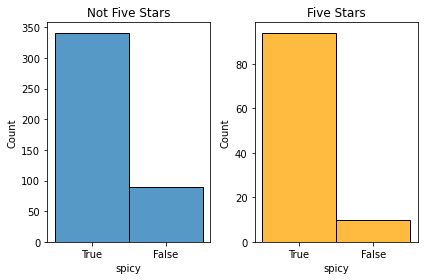

Not 5-Star t/f ratio: 79%
Is 5-Star t/f ratio: 90%
Percent Difference of Is 5-Star / Not 5-Star: 113%
-------------------- many_5stars_country --------------------
False    1234
True      281
Name: many_5stars_country, dtype: int64


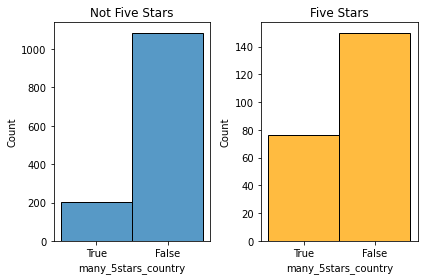

Not 5-Star t/f ratio: 15%
Is 5-Star t/f ratio: 33%
Percent Difference of Is 5-Star / Not 5-Star: 211%
-------------------- moderate_5stars_country --------------------
False    955
True     560
Name: moderate_5stars_country, dtype: int64


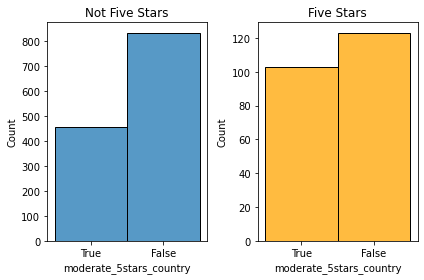

Not 5-Star t/f ratio: 35%
Is 5-Star t/f ratio: 45%
Percent Difference of Is 5-Star / Not 5-Star: 128%
-------------------- few_5stars_country --------------------
False    1102
True      413
Name: few_5stars_country, dtype: int64


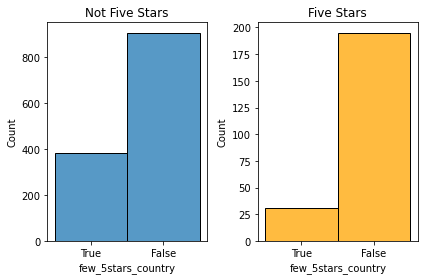

Not 5-Star t/f ratio: 29%
Is 5-Star t/f ratio: 13%
Percent Difference of Is 5-Star / Not 5-Star: 46%
-------------------- unknown_5stars_country --------------------
False    1254
True      261
Name: unknown_5stars_country, dtype: int64


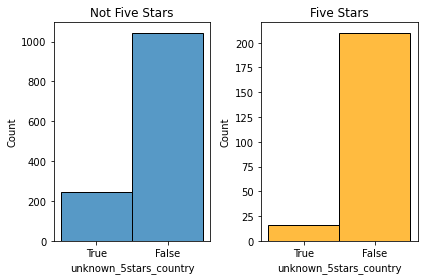

Not 5-Star t/f ratio: 19%
Is 5-Star t/f ratio: 7%
Percent Difference of Is 5-Star / Not 5-Star: 37%
-------------------- many_5stars_flavor --------------------
False    1390
True      125
Name: many_5stars_flavor, dtype: int64


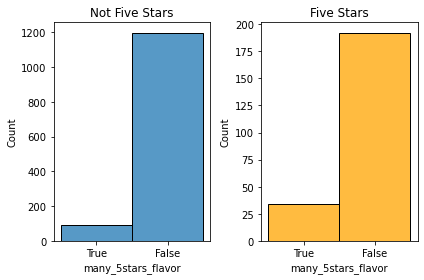

Not 5-Star t/f ratio: 7%
Is 5-Star t/f ratio: 15%
Percent Difference of Is 5-Star / Not 5-Star: 213%
-------------------- moderate_5stars_flavor --------------------
False    1311
True      204
Name: moderate_5stars_flavor, dtype: int64


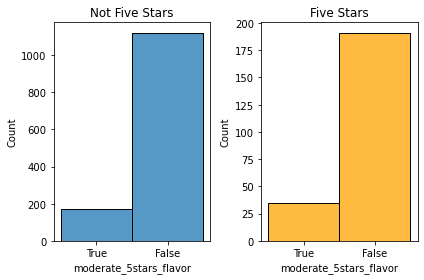

Not 5-Star t/f ratio: 13%
Is 5-Star t/f ratio: 15%
Percent Difference of Is 5-Star / Not 5-Star: 118%
-------------------- few_5stars_flavor --------------------
False    1191
True      324
Name: few_5stars_flavor, dtype: int64


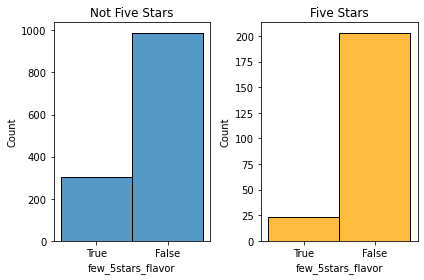

Not 5-Star t/f ratio: 23%
Is 5-Star t/f ratio: 10%
Percent Difference of Is 5-Star / Not 5-Star: 43%
-------------------- unknown_5stars_flavor --------------------
False    1255
True      260
Name: unknown_5stars_flavor, dtype: int64


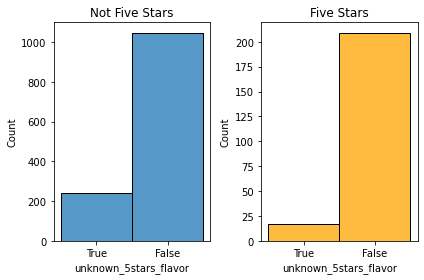

Not 5-Star t/f ratio: 18%
Is 5-Star t/f ratio: 7%
Percent Difference of Is 5-Star / Not 5-Star: 39%


In [22]:
# visualize target/non-target charts for each feature here
# include exact numbers and proportions
explore.bivariate_bars(train)

## Features Against the Target - Results
These results come from the above visualizations. Simply put, it compares the ratio in the blue charts against the ratio in the orange charts. **Larger differences in ratio are great as features for a predictive model.**
> - **spicy: 13% increase;** 79% ratio in Not 5-Star -> 90% ratio in Is 5-Star
> - **many_5stars_country: 111% increase;** 15% ratio in Not 5-Star -> 33% ratio in Is 5-Star
> - **moderate_5stars_country: 28% increase;** 35% ratio in Not 5-Star -> 45% ratio in Is 5-Star
> - **few_5stars_country: 54% decrease;** 29% ratio in Not 5-Star -> 13% ratio in Is 5-Star
> - **unknown_5stars_country: 63% decrease;** 19% ratio in Not 5-Star -> 7% ratio in Is 5-Star
> - **many_5stars_flavor: 113% increase;** 7% ratio in Not 5-Star -> 15% ratio in Is 5-Star
> - **moderate_5stars_flavor: 18% increase;** 13% ratio in Not 5-Star -> 15% ratio in Is 5-Star
> - **few_5stars_flavor: 57% decrease;** 23% ratio in Not 5-Star -> 10% ratio in Is 5-Star
> - **unknown_5stars_flavor: 61% decrease;** 18% ratio in Not 5-Star -> 7% ratio in Is 5-Star

**All of these features are technically valid for the model. We will recreate these features in wrangle.py for each data split.**

# <center>Model
## Bottom Line Up Front: What I Did for Model
- Prepared entire dataset with model features
- Chose F1 Score as our main evaluation metric due to prioritizing accuracy in presence of imbalanced classes
- Split dataset into Train, Validate, and Test
- Applied SMOTE+Tomek resampling to fix the class imbalance in our target for the Train split
- Built, fit several classification models and hyperparameter combinations on resampled Train split
- Evaluated baseline and all model performances on Validate, chose best model (Logistic Regression)
- Chose not to use Grid Search to optimize hyperparameters due to nature of Logistic Regression hyperparameters
- Evaluated baseline and best model's ROC Curve AUC
- Evaluated baseline and best model on sequestered Test split
    
# Model Preparation
## Preparing All Data Splits
Here, we start with the original data, create the same final features as created above, then split the data into our model training split and our two out-of-sample splits. Validate will be used to choose our best model and Test will be used to evaluate our best model a second time.

In [23]:
# import prepared data
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.prep_model()
# check import
X_train.shape, X_validate.shape, X_test.shape

Train size: (1515, 11) Validate size: (506, 11) Test size: (506, 11)


((1515, 10), (506, 10), (506, 10))

## Handling Class Imbalance
We will need to resample our training split so that the classes are balanced. This will improve the performance of our models.

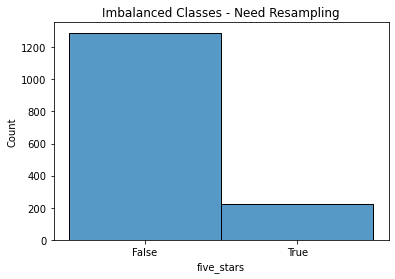

In [24]:
# display class imbalance
sns.histplot(y_train.astype('string'))
plt.title('Imbalanced Classes - Need Resampling')
plt.show()

In [25]:
# resample classes in train split
X_train, y_train = model.resampler(X_train, y_train)

Before SMOTE+Tomek applied: (1515, 10) (1515,)
After SMOTE+Tomek applied: (2578, 10) (2578,)


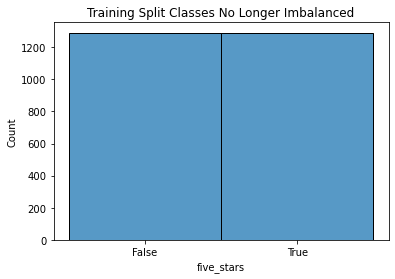

In [26]:
# show results of resampling
sns.histplot(y_train.astype('string'))
plt.title('Training Split Classes No Longer Imbalanced')
plt.show()

## Model Priorities
Before building a model, we should first consider which evaluation metric to optimize for.
1. Should we focus on capturing as many five-star reviews as possible? (Recall/Sensitivity)
2. Should we focus on limiting incorrect five-star review guesses? (Precision)
3. Should we focus on **guessing the minority class while retaining overall accuracy?** (F1 Score)
4. Should we focus on accurately classifying five-star and not-five-star reviews equally? (Accuracy)
5. Should we focus on capturing as many not-five-star reviews as possible? (Specificity)

Since our goal is to predict five-star reviews (the minority class) while being accurate overall, **we should use the F1 Score as our main evaluation metric.**

# Model Creation
Now that the data is prepared and we've picked our main evaluation metric, this is our plan for modeling:
1. First, we will create multiple standard models from a script I created.
2. We will see which algorithms seem to perform best for F1 Score on the Validate split (our repeat-access out-of-sample split)
3. We will choose one algorithm and use Grid Search to optimize hyperparameters for F1 Score
4. We will choose 5 hyperparameter combinations and generate ROC Curves and calculate ROC AUC for each
5. We will pick the model with the highest AUC (best model)
6. Finally, evaluate model on Test split (our sequestered out-of-sample split)

## Creating Standard Classification Models - Script
My script creates the following models:
1. Choose Most Common Class as Prediction (Mode Baseline)
2. Decision Tree (DecisionTreeClassifier), max_depths = [1,2,3,5,10]
3. Random Forest (RandomForestClassifier), max_depths = [1,2,3,5,10]
4. Logistic Regression (LogisticRegression)
5. Naive Bayes (GaussianNB), smooth_levels = [.00001, .0001, .001, .01, 10, 100]
6. K-Nearest Neighbors (KNeighborsClassifier), neighbor_counts = [3,5,10,25,75]

It **fits** these models on our Train split and **generates predictions for Train and Validate** splits. Then it **returns a predictions dataframe** where the first column is the actual observed values and each additional column contains one model's predictions. **This predictions dataframe will be put through an evaluation function** in the next section.

In [27]:
# run the script
y_train_preds, y_val_preds = model.classification_shotgun(X_train, y_train, X_validate, y_validate)

[18:36:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:46] WARNING: /Users/runner/miniforge3/cond

Additionally, we will need to generate a column of predictions for our minority class. This will be used to compare the baseline against the models on out-of-sample data.

In [28]:
# add prediction column for five_stars = True (minority class)
y_train_preds, y_val_preds = model.manual_baseline(y_train_preds, y_val_preds, True)

Let's check to make sure everything worked properly.

In [29]:
# check the results of script for train
y_train_preds.head()

,in_actuals,mode_baseline,tree_maxdepth1,tree_maxdepth2,tree_maxdepth3,tree_maxdepth5,tree_maxdepth10,rf_depth1,rf_depth2,rf_depth3,...,knn_n3,knn_n5,knn_n10,knn_n25,knn_n75,xgb_maxdepth3,xgb_maxdepth5,xgb_maxdepth7,xgb_maxdepth9,manual_baseline
0,False,False,False,True,True,True,True,True,True,True,...,False,False,False,False,False,True,True,True,True,True
1,True,False,False,False,False,True,True,False,False,True,...,True,False,False,True,True,True,True,True,True,True
2,False,False,False,True,True,True,True,True,True,True,...,False,False,False,False,True,True,True,True,True,True
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,True,True,False,False,True,...,True,True,False,True,True,True,True,True,True,True


In [30]:
# check the results of script for validate
y_val_preds.head()

,out_actuals,mode_baseline,tree_maxdepth1,tree_maxdepth2,tree_maxdepth3,tree_maxdepth5,tree_maxdepth10,rf_depth1,rf_depth2,rf_depth3,...,knn_n3,knn_n5,knn_n10,knn_n25,knn_n75,xgb_maxdepth3,xgb_maxdepth5,xgb_maxdepth7,xgb_maxdepth9,manual_baseline
1264,False,False,False,True,True,True,True,True,True,True,...,False,False,False,False,False,True,True,True,True,True
367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1029,False,False,False,True,True,True,True,True,True,True,...,True,False,False,False,False,True,True,True,True,True
1391,True,False,False,True,True,True,True,True,True,True,...,False,False,False,False,False,True,True,True,True,True
527,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## First Evaluation: Initial Models and F1 Score
Now that we have predictions dataframes, we will push these dataframes through our evaluation script and check which models scored highest on F1 score.

In [31]:
# build dataframe for model performance metrics
model_performances = model.print_classification_results(y_train_preds, y_val_preds)

# sort results by top-F1 score
model_performances[['Model','OutSample_F1_Score']].sort_values(by='OutSample_F1_Score', ascending=False).head(7)

,Model,OutSample_F1_Score
11,logit,0.3841
17,nb_vsmooth100,0.3767
16,nb_vsmooth10,0.3767
8,rf_depth3,0.3734
9,rf_depth5,0.3718
14,nb_vsmooth0.001,0.3679
15,nb_vsmooth0.01,0.3679


### Results of First Evaluation
- Always-Guess-Five-Star-Rating baseline on out-of-sample F1 Score: 28%
- Our best algorithms on out-of-sample F1 Score:
    * Logistic Regression (38%)
    * Gaussian Naive Bayes (37%)
    * Random Forest Classifier (37%)
    
## Second Evaluation: Grid Search
Now, we will apply Grid Search on Gaussian Naive Bayes and Random Forest Classifier to see which hyperparameter combination works best. We won't use Grid Search on Logistic Regression because its hyperparameters are not well-suited for the iteration technique involved with Grid Search.

### Grid Search for GaussianNB

In [32]:
# create grid
nb_grid = GridSearchCV(estimator=GaussianNB(),
                       param_grid={'var_smoothing':[.001, .01, .1, 10, 100, 1000]},
                       scoring='f1',
                       cv=5)

# fit grid on train, calculate best var_smoothing
nb_grid.fit(X_train, y_train)
results = nb_grid.best_estimator_
results

GaussianNB(var_smoothing=100)

### Grid Search for Random Forest Classifier

In [33]:
# create grid
rf_grid = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid={'max_depth':[5,6,7,8,9],
                                   'min_samples_leaf':[1,2,3]},
                       scoring='f1',
                       cv=5)

# fit grid on train, calculate best hyperparameter combination
rf_grid.fit(X_train, y_train)
results = rf_grid.best_estimator_
results

RandomForestClassifier(max_depth=9)

Best hyperparameter combinations:
> - Gaussian Naive Bayes: var_smoothing=100
> - Random Forest Classifier: max_depth=7, min_samples_leaf=1

## Third Evaluation: ROC Curve AUC
Using our top three models, we will create ROC Curves and calculate area under the curve (AUC) to see which model performs best. We will choose that model as our best performing model of all models.

In [34]:
# create and fit the top three models and baseline
logit = LogisticRegression(random_state=123).fit(X_train, y_train)
nb = GaussianNB(var_smoothing=100).fit(X_train, y_train)
rf = RandomForestClassifier(max_depth=7, random_state=123).fit(X_train, y_train)

In [35]:
# only use prediction percentages for five-star ratings
# baseline
bl_probs = [True for _ in range(len(y_validate))]
# logistic regression
logit_probs = logit.predict_proba(X_validate)
logit_probs = logit_probs[:,1]
# naive bayes
nb_probs = nb.predict_proba(X_validate)
nb_probs = nb_probs[:,1]
# random forest
rf_probs = rf.predict_proba(X_validate)
rf_probs = rf_probs[:,1]

In [36]:
# calculate ROC AUC for baseline and our models
bl_auc = roc_auc_score(y_validate, bl_probs)
logit_auc = roc_auc_score(y_validate, logit_probs)
nb_auc = roc_auc_score(y_validate, nb_probs)
rf_auc = roc_auc_score(y_validate, rf_probs)

In [37]:
# print ROC AUC for baseline and our models
print('Baseline: ROC AUC=%.3f' % (bl_auc))
print('Logistic Regression: ROC AUC=%.3f' % (logit_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

Baseline: ROC AUC=0.500
Logistic Regression: ROC AUC=0.703
Naive Bayes: ROC AUC=0.685
Random Forest: ROC AUC=0.669


In [38]:
# generate ROC curve for baseline and our models
bl_fpr, bl_tpr, _ = roc_curve(y_validate, bl_probs)
logit_fpr, logit_tpr, _ = roc_curve(y_validate, logit_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_validate, nb_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_validate, rf_probs)

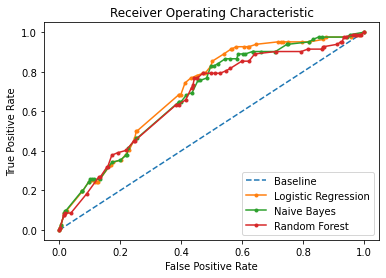

In [39]:
# plot ROC curve for baseline and our models
plt.plot(bl_fpr, bl_tpr, linestyle='--', label='Baseline')
plt.plot(logit_fpr, logit_tpr, marker='.', label='Logistic Regression')
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

## Overall Results of Model Creation
> - Best Model: Logistic Regression
> - Baseline F1 Score: 28%
> - Our F1 Score: 34%
> - Baseline ROC AUC: 50%
> - Our ROC AUC: 70%

# Evaluating Best Model on Test Split
Now, we will check our best model's F1 Score for our sequestered out-of-sample split.

In [40]:
# prepare y_test for evaluation
y_test = pd.DataFrame(y_test)

In [41]:
# add columns for predictions and baseline
y_test['predictions'] = logit.predict(X_test)
y_test['baseline'] = True

In [42]:
# calculate f1 scores
baseline_f1_score = f1_score(y_test['five_stars'], y_test['baseline'])
predictions_f1_score = f1_score(y_test['five_stars'], y_test['predictions'])

In [43]:
# output f1 scores
print(f'Baseline F1 Score: {int(baseline_f1_score * 100)}%')
print(f'Best Model F1 Score: {int(predictions_f1_score * 100)}%')

Baseline F1 Score: 24%
Best Model F1 Score: 28%


# <center>Conclusion
- **Using nothing more than analyzing ramen product names, I was able to build several categorical features that incorporated domain knowledge and translation for keywords in product names.**
- **Using statistical testing, we reduced features to only the features that were related to our target.** 
- **In the end, our predictive model outperformed the baseline on common evaluation metrics for unseen data.**